# 이미지 전처리 코드


In [29]:
# OpenCV 전처리 함수
def preprocess_digit(roi_img, debug=False):
    # 1. ROI 의 가장자리 5픽셀을 잘라내기 (Border 제거)
    # 너무 많이 잘라낼 경우 경계면에 안 닿은 일반 숫자도 제거해버려서 적당히 5픽셀 정도만 제거
    offset = 5
    roi_clean = roi_img[offset:-offset, offset:-offset]

    # 2. 그레이스케일 변환 및 대비 향상 -> 이진화 위해
    gray_image = cv2.cvtColor(roi_clean, cv2.COLOR_BGR2GRAY)

    # 이미지 반전 (핸드폰 이미지 캡쳐시 반대로 나옴)
    gray_image = np.flip(gray_image, 1)

    # 빛 반사 줄이기 위해 clahe 사용했는데 큰 의미는 없는 것 같음
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_gray = clahe.apply(gray_image)

    # 잡음 제거
    # blur = cv2.medianBlur(gray_image, 5)
    blur = cv2.GaussianBlur(enhanced_gray, (5, 5), 3)
    # blur = cv2.bilateralFilter(gray_image, 9, 75, 75) # 9: 필터 크기, 75: 색 공간 표준편차, 75: 좌표 공간 표준편차

    # 핵심: 적응형 이진화(adaptive thresholding)
    # 얇은 글자를 선명하게 살려냄
    # INV 를 써서 처음부터 배경을 검정색으로 만들기 -> bitwise 대신
    binary = cv2.adaptiveThreshold(blur,
                                       255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 21, 5) # C 값을 7에서 5로 낮춰 더 민감하게 잡음

    kernel = np.ones((5, 5), np.uint8)

    # 팽창을 너무 과하게 하면 빛(잡음)까지 커져서 숫자로 인식함
    # 하지만 침식을 너무 많이 하면 글자가 끊겨보임 -> 적절하게 조절 필요
    # closed_img = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    # processed_img = cv2.dilate(closed_img, kernel, iterations=2)

    # 팽창 후 침식 3번
    processed_img = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2) # 다시 한번 깎기

    if (debug == True):
        cv2.imshow("gray_image", gray_image)
        cv2.imshow("clahe", enhanced_gray)
        cv2.imshow("blur", blur)
        cv2.imshow("binary1", binary)

    return processed_img

In [30]:
# 외곽선으로 숫자 찾아내기
def extract_digits(processed_img, num_digits=1, debug=False):
    # 1. 외곽선 찾기
    # RETR_LIST 사용시 6 검출할 때 0 도 같이 검출됨
    contours, _ = cv2.findContours(processed_img.copy(),
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE
                                   )

    # 디버그 모드 시 시각화용 복사본 생성 (원본 보존)
    if debug:
        contour_view = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2BGR)
        # 검출된 모든 외곽선을 초록색으로 그림
        cv2.drawContours(contour_view, contours, -1, (0, 255, 0), 2)

    roi_h, roi_w = processed_img.shape
    roi_area = roi_h * roi_w
    digit_rects = []

    # 2. 숫자 후보 필터링
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        print("x, y, w, h : ", x, y, w, h)
        print("area : ", area)

        # 너무 큰 덩어리 제외 (테두리 등)
        if area > (roi_area * 0.95): continue
        # 너무 작은 잡음 제외
        if area < 300: continue
        # 경계면에 닿은 덩어리 제외 (마진 설정)
        margin = 5 # 너무 크게 주면 숫자도 인식 안함
        # 종횡비 체크 (가로로 긴 것은 제외)
        aspect_ratio = w / float(h)
        if aspect_ratio > 3.0:
            continue

        # 경계면에 닿아있는가?
        is_margin = x < margin or y < margin or (x+w) > (roi_w - margin) or (y+h)  > (roi_h-margin)
        if is_margin: continue

        digit_rects.append((x, y, w, h))

    # 3. 면적 순으로 정렬 후 상위 4개 선택 (비밀번호 4자리 기준)
    digit_rects = sorted(digit_rects, key=lambda r: r[2]*r[3], reverse=True)[:num_digits]

    # 4. 왼쪽에서 오른쪽 순서로 다시 정렬 (비밀번호 순서)
    digit_rects.sort(key=lambda r: r[0])

    digit_images = []
    padding = 15

    # 5. 각 영역 크롭 및 리사이즈
    for i, (x, y, w, h) in enumerate(digit_rects):
        if debug:
            cv2.rectangle(contour_view, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(contour_view, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        x1, y1 = max(0, x-padding), max(0, y-padding)
        x2, y2 = min(roi_w, x+w+padding), min(roi_h, y+h+padding)

        # 슬라이싱
        digit_crop = processed_img[y1:y2, x1:x2]

        # 28 * 28 로 리사이즈
        resized_img = cv2.resize(digit_crop, (28, 28), interpolation=cv2.INTER_AREA)
        digit_images.append(resized_img)

        if debug:
            cv2.rectangle(contour_view, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.imshow(f"Debug_Crop_{i}", resized_img)

    if debug:
        cv2.imshow("Debug_Contours_and_Boxes", contour_view)
    return digit_images, digit_rects

# 사용자 글씨 캡쳐

In [3]:
# 학습용 글씨 생성
import random
from scipy.ndimage import gaussian_filter

def apply_elastic_transform(image, alpha=35, sigma=4):
    """이미지를 젤리처럼 뒤트는 탄성 변형 적용"""
    random_state = np.random.RandomState(None)
    shape = image.shape

    # 무작위 변위 필드 생성 (가우시안 필터로 부드럽게 만듦)
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    # 픽셀 좌표 맵 생성
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype('float32')
    map_y = (y + dy).astype('float32')

    return cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

def augment_image_opencv(img, count=10, debug=False):
    aug_images = []
    h, w = img.shape[:2]

    for i in range(count):
        # 탄성 변형
        # 70% 확률로 적용하여 원본 형태도 유지
        transformed = img.copy()
        if random.random() > 0.3:
            transformed = apply_elastic_transform(transformed, alpha=random.uniform(25, 35), sigma=random.uniform(3, 4))
            cv2.imshow("transformed", transformed)

        # 투영 변환
        margin = 3
        src_pts = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        dst_pts = np.float32([
            [random.uniform(0, margin), random.uniform(0, margin)],
            [w - random.uniform(0, margin), random.uniform(0, margin)],
            [random.uniform(0, margin), h - random.uniform(0, margin)],
            [w - random.uniform(0, margin), h - random.uniform(0, margin)]
        ])
        M_persp = cv2.getPerspectiveTransform(src_pts, dst_pts)
        transformed = cv2.warpPerspective(transformed, M_persp, (w, h), borderValue=0)
        cv2.imshow("warpPerspective", transformed)

        # 어파인 변환: 기울기(Shearing) 및 크기(Scaling)
        # Shear: 글씨가 옆으로 누운 정도 조절
        shear_factor = random.uniform(-0.15, 0.15)
        M_shear = np.float32([[1, shear_factor, 0], [0, 1, 0]])
        transformed = cv2.warpAffine(transformed, M_shear, (w, h), borderValue=0)
        cv2.imshow("warpAffine1", transformed)

        # Scale: 크기를 90%~110% 사이로 조절
        scale = random.uniform(0.9, 1.1)
        M_scale = cv2.getRotationMatrix2D((w/2, h/2), 0, scale)
        transformed = cv2.warpAffine(transformed, M_scale, (w, h), borderValue=0)
        cv2.imshow("warpAffine2", transformed)

        # 무작위 회전 및 이동
        angle = random.uniform(-15, 15)
        tx = random.uniform(-2, 2)
        ty = random.uniform(-2, 2)
        M_rot = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        M_rot[0, 2] += tx
        M_rot[1, 2] += ty
        transformed = cv2.warpAffine(transformed, M_rot, (w, h), borderValue=0)
        cv2.imshow("warpAffine3", transformed)

        # 선명하게 (Sharpening)
        if random.random() > 0.5:
            kernel_sharp = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]])
            transformed = cv2.filter2D(transformed, -1, kernel_sharp)
            cv2.imshow("kernel_sharp", transformed)

        # 두께 변화 (Dilation/Erosion) 수정
        # 침식(erode) 확률을 낮추고, 커널 크기를 2x2로 최소화함
        # random.choices의 weights를 통해 각 연산의 발생 빈도를 조절
        option = ['dilate', 'erode', 'none']
        weights = [0.4, 0.1, 0.5]  # 침식(erode)은 10% 확률로만 발생하게 설정
        choice = random.choices(option, weights=weights)[0]

        if choice != 'none':
            # 28x28 이미지에서는 2x2 커널이 마지노선임
            kernel_morph = np.ones((2, 2), np.uint8)
            if choice == 'dilate':
                transformed = cv2.dilate(transformed, kernel_morph, iterations=1)
            elif choice == 'erode':
                # 침식 적용 전, 이미지가 너무 깨지지 않도록 한 번 더 확인하거나
                # 아주 얇은 획을 가진 숫자라면 이 단계를 건너뛰는 것이 좋음
                transformed = cv2.erode(transformed, kernel_morph, iterations=1)
        cv2.imshow("dilate or erode", transformed)
        aug_images.append(transformed)

    return aug_images

In [7]:
# 학습용 이미지 캡처
from datetime import datetime

def capture_user_dataset():
    cap = cv2.VideoCapture(0)
    base_path = "dataset"
    for i in range(10):
        os.makedirs(f"{base_path}/{i}", exist_ok=True)

    # UI 상태 제어 변수
    last_digit = ""
    display_timer = 0  # 텍스트 표시 시간(프레임 수)
    flash_timer = 0    # 플래시 효과 시간(프레임 수)

    print("수집 시작: 숫자 키 (0~9)를 누르면 저장, 'esc'종료")

    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.flip(frame, 1)
        h, w, _ = frame.shape

        size = 300
        x1, y1 = (w-size)//2, (h-size)//2
        roi = frame[y1:y1+size, x1:x1+size].copy()

        # --- 메인 화면 그리기 ---
        # 1. ROI 가이드라인
        cv2.rectangle(frame, (x1, y1), (x1+size, y1+size), (0, 255, 0), 2)

        # 2. 캡처 시 플래시 효과 (화면을 하얗게 덮음)
        if flash_timer > 0:
            # 흰색 배경 생성 후 원본과 합성 (0.7 비율로 불투명하게)
            overlay = frame.copy()
            overlay[:] = (255, 255, 255)
            cv2.addWeighted(overlay, 0.7, frame, 0.3, 0, frame)
            flash_timer -= 1

        # 3. 마지막 캡처 숫자 안내 (타이머 동안만 표시)
        if display_timer > 0:
            msg = f"CAPTURED: {last_digit}"
            # 글자 배경(검은색)을 넣어 가독성 확보
            cv2.putText(frame, msg, (x1 + 52, y1 + 152), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 4)
            # 실제 글자(초록색)
            cv2.putText(frame, msg, (x1 + 50, y1 + 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            display_timer -= 1

        # 4. 상단 안내 문구
        cv2.putText(frame, "Press 0-9 to Save", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        cv2.imshow("Capture Mode", frame)

        key = cv2.waitKey(1) & 0xFF

        # 숫자 입력 처리
        if ord('0') <= key <= ord('9'):
            digit = chr(key)
            last_digit = digit

            # 시각 효과 트리거
            flash_timer = 3      # 3프레임 동안 하얗게
            display_timer = 30   # 약 1초 동안(30fps 기준) 글자 표시

            # --- 데이터 저장 로직 ---
            try:
                # 이미지 전처리
                processed = preprocess_digit(roi)

                # 숫자만 잘라내기
                digit_images, _ = extract_digits(processed, num_digits=1)

                if digit_images:
                    # 숫자 1개만 가져오기
                    d_img = digit_images[0]

                    # 1개의 이미지로 여러개의 학습용 이미지 생성
                    augmented_list = augment_image_opencv(d_img, count=30)

                    for idx, aug_img in enumerate(augmented_list):
                        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
                        filename = f"{digit}_{timestamp}_{idx}.png"
                        cv2.imwrite(os.path.join(base_path, digit, filename), aug_img)
                    print(f"[{digit}] 저장 완료")
                else:
                    print("검출 실패")
            except NameError as e:
                print(f"함수가 정의되지 않음: {e}")

        elif key == 27: # ESC
            break

    cap.release()
    cv2.destroyAllWindows()

capture_user_dataset()

수집 시작: 숫자 키 (0~9)를 누르면 저장, 'esc'종료
x, y, w, h :  117 53 118 185
area :  1002.5
[5] 저장 완료


# 모델 학습

In [8]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1단계: 데이터 준비 및 정규화
# 데이터를 다시 합치지 않고 처음부터 train과 test로 나누어 로드함
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 정규화: 0~255 사이의 값을 0~1 사이로 변환
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 채널 차원 추가 (28, 28) -> (28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# 2단계: 가벼운 CNN 모델 설계
def create_simple_model():
    # Adam이라는 유능한 내비게이션을 옆에 두고, 돋보기(Conv2D)로 특징을 찾아 요약(Pooling)한 뒤, 똑똑한 뇌(Dense)로 판단해서 0~9까지의 확률(Softmax)을 내놓는 기계를 만든 것
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'), # 돋보기: 이미지의 구석구석을 돋보기로 훑으며 특징을 찾아냄
        layers.MaxPooling2D((2, 2)), # 요약하기: 돋보기로 찾은 정보들 중 중요한 것만 남기고 나머지는 버림. 데이터 크기 줄여서 계산 빠르게 만듦.
        layers.Flatten(), # 줄세우기: 2차원 평면 이미지를 한 줄로 길게 펼침
        layers.Dense(128, activation='relu'), # Dense(판단하는 뇌): 펼쳐진 정보를 보고 최종 판단을 내리는 신경망. relu: 필요한 정보만 통과시키는 필터
        layers.Dropout(0.2), # 학습할 때 신경망의 일부를 의도적으로 꺼서 특정 노드에 의존하지 않게 함
        layers.Dense(10, activation='softmax') # softmax: 확률발표
    ])

    # Optimizer(최적화 도구): "정답으로 가는 길을 찾아주는 내비게이션"
    # Adam: "가장 성능 좋은 최신형 내비게이션"
    model.compile(optimizer='adam', # adam: 정답 틀릴 때마다 정답 쪽으로 조금씩 이동해야 하는데, Adam은 그 이동하는 속도와 방향을 아주 영리하게 조절
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 모델 생성
model = create_simple_model()

# 3단계: 모델 학습
# validation_split을 통해 학습 데이터 중 20%를 검증용으로 사용
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

# 4단계: 평가 및 저장
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\n테스트 정확도: {test_acc:.4f}')

model.save("default_model.keras")

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9445 - loss: 0.1863 - val_accuracy: 0.9812 - val_loss: 0.0679
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9791 - loss: 0.0688 - val_accuracy: 0.9810 - val_loss: 0.0623
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9857 - loss: 0.0458 - val_accuracy: 0.9842 - val_loss: 0.0551
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9897 - loss: 0.0330 - val_accuracy: 0.9861 - val_loss: 0.0475
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9914 - loss: 0.0259 - val_accuracy: 0.9862 - val_loss: 0.0490
313/313 - 3s - 9ms/step - accuracy: 0.9866 - loss: 0.0442

테스트 정확도: 0.9866


In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 0. 모델 빌드 함수
def build_model():
    # 총 레이어 수: 기능적으로 약 12개의 층으로 구성되어 있다.
    # 주요 구성 요소:
    # 입력층(Input): 28x28 흑백 이미지 수용
    # 합성곱층(Conv2D): 3개 (이미지 특징 찾기)
    # 배치 정규화(BatchNormalization): 2개 (안정적인 학습)
    # 풀링층(MaxPooling2D): 2개 (데이터 압축)
    # 완전 연결층(Dense): 2개 (최종 판단)
    # 기타: Flatten(줄세우기), Dropout(과적합 방지)
    # 특징 찾기 -> 요약하기 -> 줄 세우기 -> 판단하기
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'), # padding='same': 이미지를 훑을 때 가장자리 부분이 잘려 나가지 않도록 이미지 테두리에 가상의 0을 채워줌
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'), # 돋보기의 개수를 늘리기(64)
        layers.BatchNormalization(), # 각 층을 통과할 때마다 데이터 숫자들이 너무 커지거나 작아지지 않게 일정한 범위로 계속 다듬어줌 -> 학습속도 빨라짐
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'), # 뇌의 크기를 키우기(256)
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# 1. 데이터 준비
(x_mnist, y_mnist), (x_test, y_test) = keras.datasets.mnist.load_data()
x_mnist = x_mnist.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# 사용자 데이터 로드
user_images, user_labels = [], []
base_path = "dataset"

for digit in range(10):
    dir_path = os.path.join(base_path, str(digit))
    if not os.path.exists(dir_path): continue
    for img_name in os.listdir(dir_path):
        img = cv2.imread(os.path.join(dir_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (28, 28))
            user_images.append(img)
            user_labels.append(digit)

user_x = np.array(user_images).reshape(-1, 28, 28, 1).astype('float32') / 255.0
user_y = np.array(user_labels)

# 사용자 데이터 오버샘플링 (20배)
user_x_oversampled = np.repeat(user_x, 20, axis=0)
user_y_oversampled = np.repeat(user_y, 20, axis=0)
print(f"학습에 사용될 사용자 데이터 수: {len(user_x_oversampled)}개")

# 2. [Phase 1] MNIST 기초 학습
print("\n--- Phase 1: MNIST Pre-training ---")
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_mnist, y_mnist, epochs=3, batch_size=128, validation_split=0.1)

# ==========================================
# 3. [Phase 2] 최종 모델 파인 튜닝
# ==========================================
print("\n--- Phase 2: Fine-tuning with User Data (Final Model) ---")

datagen = ImageDataGenerator( # 이미지를 돌리고 비틀어서 모델이 특정 모양만 외우지 못하게 방해함
    rotation_range=20, width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.2, shear_range=0.15, fill_mode='constant', cval=0
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy', metrics=['accuracy']
)

# 혼합 데이터 생성 (사용자 데이터 + MNIST 39000개)
indices = np.random.choice(len(x_mnist), 39000, replace=False)
mixed_x = np.concatenate((user_x_oversampled, x_mnist[indices]), axis=0)
mixed_y = np.concatenate((user_y_oversampled, y_mnist[indices]), axis=0)

model.fit(datagen.flow(mixed_x, mixed_y, batch_size=64), epochs=5, verbose=1)
model.save("finetuned_digit_model.keras")

학습에 사용될 사용자 데이터 수: 39540개

--- Phase 1: MNIST Pre-training ---
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 143ms/step - accuracy: 0.9366 - loss: 0.2211 - val_accuracy: 0.9525 - val_loss: 0.1680
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 59s 139ms/step - accuracy: 0.9771 - loss: 0.0755 - val_accuracy: 0.9888 - val_loss: 0.0403
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 52s 122ms/step - accuracy: 0.9838 - loss: 0.0554 - val_accuracy: 0.9918 - val_loss: 0.0284

--- Phase 2: Fine-tuning with User Data (Final Model) ---
Epoch 1/5
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.5254 - loss: 1.9524
Epoch 2/5
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - accuracy: 0.6114 - loss: 1.2531
Epoch 3/5
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 118s 96ms/step - accuracy: 0.6829 - loss: 1.0137
Epoch 4/5
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 112s 91ms/step - accuracy: 0.7352 - loss: 0.8428
Epoch 5/5
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 97s 79ms/step - accuracy: 0.7686 - loss: 0.7326


# 모델 비교

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
=== [모델 성능 비교 요약] ===
             Metric  Simple Model  Fine-tuned Model
0  Overall Accuracy      0.985200          0.989300
1   Precision (Avg)      0.985439          0.989204
2      Recall (Avg)      0.985021          0.989226




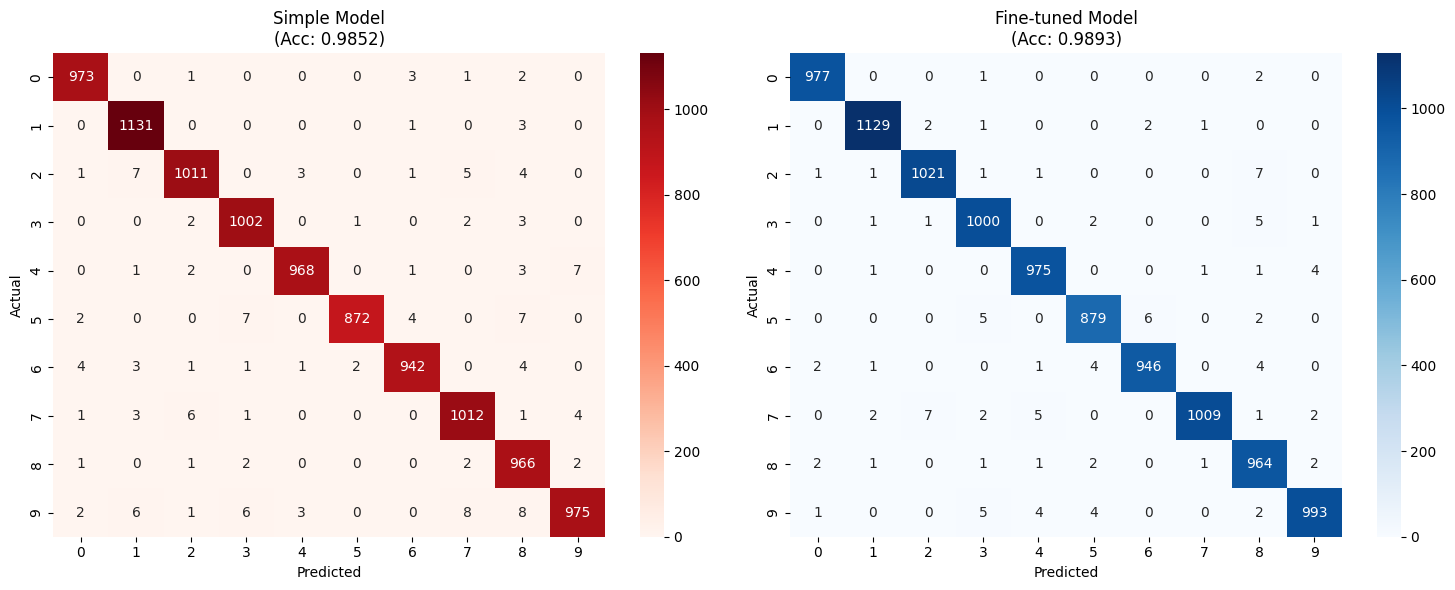

--- [숫자 '8'에 대한 집중 분석] ---
Simple Model Recall: 0.9918
Fine-tuned Model Recall: 0.9897
개선도: -0.21% 향상


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def compare_models_visual(model1_path, model2_path, x_test, y_test):
    # 1. 모델 로드
    m1 = keras.models.load_model(model1_path)
    m2 = keras.models.load_model(model2_path)

    # 2. 예측값 계산
    y_pred1 = np.argmax(m1.predict(x_test), axis=1)
    y_pred2 = np.argmax(m2.predict(x_test), axis=1)

    # 3. 성적표(Classification Report) 생성
    report1 = classification_report(y_test, y_pred1, output_dict=True)
    report2 = classification_report(y_test, y_pred2, output_dict=True)

    # 4. Pandas를 이용한 주요 지표 비교표 (파일 1~2에서 배운 데이터프레임 활용)
    metrics = ['accuracy', 'macro avg']
    compare_df = pd.DataFrame({
        'Metric': ['Overall Accuracy', 'Precision (Avg)', 'Recall (Avg)'],
        'Simple Model': [report1['accuracy'], report1['macro avg']['precision'], report1['macro avg']['recall']],
        'Fine-tuned Model': [report2['accuracy'], report2['macro avg']['precision'], report2['macro avg']['recall']]
    })

    print("=== [모델 성능 비교 요약] ===")
    print(compare_df)
    print("\n")

    # 5. 오차 행렬 시각화 (파일 5의 핵심 내용)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    cm1 = confusion_matrix(y_test, y_pred1)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Reds', ax=ax[0])
    ax[0].set_title(f"Simple Model\n(Acc: {report1['accuracy']:.4f})")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")

    cm2 = confusion_matrix(y_test, y_pred2)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax[1])
    ax[1].set_title(f"Fine-tuned Model\n(Acc: {report2['accuracy']:.4f})")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # 6. 특정 숫자(예: 8)에 대한 집중 분석
    target_digit = '8'
    print(f"--- [숫자 '{target_digit}'에 대한 집중 분석] ---")
    print(f"Simple Model Recall: {report1[target_digit]['recall']:.4f}")
    print(f"Fine-tuned Model Recall: {report2[target_digit]['recall']:.4f}")
    print(f"개선도: {((report2[target_digit]['recall'] - report1[target_digit]['recall']) * 100):.2f}% 향상")

# 함수 실행
compare_models_visual("simple_digit_model.keras", "finetuned_digit_model.keras", x_test, y_test)

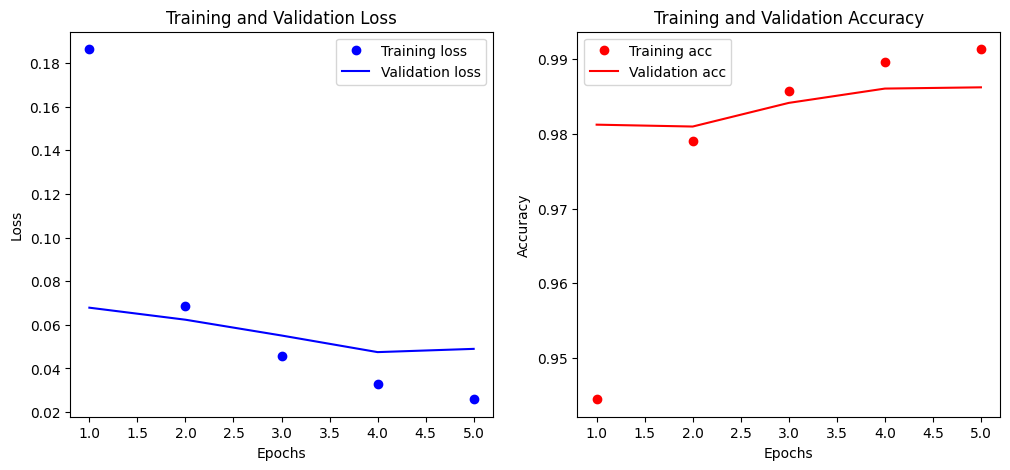

In [13]:
import matplotlib.pyplot as plt

# 학습 기록(history)에서 값 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# [왼쪽: 손실 그래프]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')   # 파란 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # 파란 선
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# [오른쪽: 정확도 그래프]
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'ro', label='Training acc')     # 빨간 점
plt.plot(epochs, val_acc, 'r', label='Validation acc')   # 빨간 선
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 메인 관련 로직

In [28]:
import cv2
import numpy as np
from tensorflow import keras

# 1. 초기 설정
print("=== 시스템 초기화 ===")
raw_pw = input("설정할 비밀번호를 입력하세요: ")
target_pw = [int(d) for d in raw_pw]
pw_len = len(target_pw)

model = keras.models.load_model("finetuned_digit_model.keras")

cap = cv2.VideoCapture(0)
captured_digits = []
status_msg = f"Progress: 0/{pw_len}"
display_color = (255, 255, 0) # 텍스트 색상
roi_color = (0, 255, 255)     # ROI 테두리 색상 (기본 노랑)
shutter_effect = 0            # 셔터 효과 타이머

while True:
    ret, frame = cap.read()
    if not ret: break
    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape

    # ROI 설정
    roi_size = 300
    x1, y1 = (w - roi_size)//2, (h - roi_size)//2
    x2, y2 = x1 + roi_size, y1 + roi_size
    roi = frame[y1:y2, x1:x2]

    # --- [효과 처리 1: 셔터 번쩍임] ---
    if shutter_effect > 0:
        # 화면을 하얗게 덮음 (찰칵 효과)
        frame = cv2.addWeighted(frame, 0.5, np.full(frame.shape, 255, dtype=np.uint8), 0.5, 0)
        shutter_effect -= 1

    # --- [UI 그리기] ---
    # ROI 테두리 (상태에 따라 roi_color가 변함)
    cv2.rectangle(frame, (x1, y1), (x2, y2), roi_color, 4)

    # 상태 메시지 배경 (가독성용)
    cv2.putText(frame, status_msg, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 1.0, display_color, 2)

    # 하단 입력 현황
    cv2.putText(frame, f"INPUT: {captured_digits}", (20, h-30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    cv2.imshow("Smart Lock System", frame)
    key = cv2.waitKey(1) & 0xFF

    # --- 'R' 키: 리셋 (모든 색상과 상태 초기화) ---
    if key == ord('r') or key == ord('R'):
        captured_digits = []
        status_msg = f"Reset! Progress: 0/{pw_len}"
        display_color = (255, 255, 0)
        roi_color = (0, 255, 255) # 노란색으로 복구
        print("초기화 완료")

    # --- 'C' 키: 캡처 및 인식 ---
    elif key == ord('c') or key == ord('C'):
        remaining_slots = pw_len - len(captured_digits)

        if remaining_slots > 0:
            shutter_effect = 3 # 3프레임 동안 화면 번쩍임

            # [기존 전처리/추출 함수 호출]
            processed = preprocess_digit(roi, debug=False)
            digit_images, rects = extract_digits(processed, num_digits=remaining_slots)

            if len(digit_images) > 0:
                for img in digit_images:
                    input_data = (img / 255.0).reshape(1, 28, 28, 1)
                    pred = model.predict(input_data, verbose=0)
                    digit = np.argmax(pred)
                    captured_digits.append(int(digit))

                    if len(captured_digits) == pw_len: break

                status_msg = f"Captured! {len(captured_digits)}/{pw_len}"
            else:
                status_msg = "No Digit Found!"
                roi_color = (0, 165, 255) # 주황색 (경고)

            # --- [결과 판정 및 효과 적용] ---
            if len(captured_digits) == pw_len:
                if captured_digits == target_pw:
                    status_msg = "SUCCESS: ACCESS GRANTED"
                    display_color = (0, 255, 0) # 초록색
                    roi_color = (0, 255, 0)     # ROI 테두리 초록색
                else:
                    status_msg = "FAILED: WRONG PASSWORD"
                    display_color = (0, 0, 255) # 빨간색
                    roi_color = (0, 0, 255)     # ROI 테두리 빨간색

    elif key == 27: break

cap.release()
cv2.destroyAllWindows()

=== 시스템 초기화 ===
x, y, w, h :  124 69 16 143
area :  454.0
x, y, w, h :  134 66 17 156
area :  509.0
x, y, w, h :  110 58 14 126
area :  352.0
x, y, w, h :  278 0 12 290
area :  1911.5
